In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, recall_score
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pickle
import warnings
warnings.filterwarnings('ignore')

print("✅ Libraries imported successfully!")
print(f"TensorFlow version: {tf.__version__}")

✅ Libraries imported successfully!
TensorFlow version: 2.19.0


In [4]:
df = pd.read_csv('https://github.com/SumantaSethi/Bank-Customer-Churn-Prediction/raw/main/Churn_Modelling_Clean.csv')

print(f"✅ Dataset loaded: {df.shape}")
print(df.head())

✅ Dataset loaded: (10000, 11)
   CreditScore Geography  Gender  Age  Tenure    Balance  NumOfProducts  \
0          619    France  Female   42       2       0.00              1   
1          608     Spain  Female   41       1   83807.86              1   
2          502    France  Female   42       8  159660.80              3   
3          699    France  Female   39       1       0.00              2   
4          850     Spain  Female   43       2  125510.82              1   

   HasCrCard  IsActiveMember  EstimatedSalary  Exited  
0          1               1        101348.88       1  
1          0               1        112542.58       0  
2          1               0        113931.57       1  
3          0               0         93826.63       0  
4          1               1         79084.10       0  


# Train-Test Split

In [5]:
X = df.drop('Exited', axis=1)
y = df['Exited']

# Initialize LabelEncoders for 'Geography' and 'Gender'
le_geo = LabelEncoder()
le_gender = LabelEncoder()

# Apply Label Encoding
X['Geography'] = le_geo.fit_transform(X['Geography'])
X['Gender'] = le_gender.fit_transform(X['Gender'])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"✅ Training set: {X_train.shape}")
print(f"✅ Test set: {X_test.shape}")
print(f"   Train churn rate: {y_train.mean()*100:.2f}%")
print(f"   Test churn rate: {y_test.mean()*100:.2f}%")

✅ Training set: (8000, 10)
✅ Test set: (2000, 10)
   Train churn rate: 20.38%
   Test churn rate: 20.35%


# Apply SMOTE

In [6]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print(f"✅ Original training size: {len(y_train)}")
print(f"✅ Resampled training size: {len(y_train_resampled)}")
print(f"✅ Class distribution after SMOTE:")
print(pd.Series(y_train_resampled).value_counts())

✅ Original training size: 8000
✅ Resampled training size: 12740
✅ Class distribution after SMOTE:
Exited
1    6370
0    6370
Name: count, dtype: int64


# Train Logistic Regression

In [7]:
from sklearn.pipeline import Pipeline

lr_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(random_state=42, max_iter=1000))
])

lr_pipeline.fit(X_train, y_train)
lr_pred = lr_pipeline.predict(X_test)
lr_recall = recall_score(y_test, lr_pred)

print(f"✅ Logistic Regression trained!")
print(f"   Recall: {lr_recall:.4f}")

# Save model
with open('logistic_regression.pkl', 'wb') as f:
    pickle.dump(lr_pipeline, f)
    print("✅ Model saved: logistic_regression.pkl")

✅ Logistic Regression trained!
   Recall: 0.1425
✅ Model saved: logistic_regression.pkl


# Train Random Forest

In [8]:
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=15,
    min_samples_split=5,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)
rf_recall = recall_score(y_test, rf_pred)

print(f"✅ Random Forest trained!")
print(f"   Recall: {rf_recall:.4f}")

# Save model
with open('random_forest.pkl', 'wb') as f:
    pickle.dump(rf_model, f)
    print("✅ Model saved: random_forest.pkl")

✅ Random Forest trained!
   Recall: 0.4545
✅ Model saved: random_forest.pkl


# Train SVM with SMOTE

In [9]:
svm_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', SVC(kernel='rbf', C=10, probability=True, random_state=42))
])

# Train on SMOTE-resampled data
svm_pipeline.fit(X_train_resampled, y_train_resampled)
svm_pred = svm_pipeline.predict(X_test)
svm_recall = recall_score(y_test, svm_pred)

print(f"✅ SVM trained!")
print(f"   Recall: {svm_recall:.4f}")

# Save model
with open('svm_smote.pkl', 'wb') as f:
    pickle.dump(svm_pipeline, f)
    print("✅ Model saved: svm_smote.pkl")

✅ SVM trained!
   Recall: 0.6609
✅ Model saved: svm_smote.pkl


# Train XGBoost

In [10]:
# Calculate scale_pos_weight for imbalance
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

xgb_model = XGBClassifier(
    n_estimators=200,
    max_depth=5,
    learning_rate=0.1,
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    eval_metric='logloss'
)

xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)
xgb_recall = recall_score(y_test, xgb_pred)

print(f"✅ XGBoost trained!")
print(f"   Recall: {xgb_recall:.4f}")

# Save model
with open('xgboost.pkl', 'wb') as f:
    pickle.dump(xgb_model, f)
    print("✅ Model saved: xgboost.pkl")

✅ XGBoost trained!
   Recall: 0.6953
✅ Model saved: xgboost.pkl


# Train Deep Learning Model

In [11]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Build model
dl_model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(32, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')
])

# Compile
dl_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', keras.metrics.Recall(name='recall')]
)

# Calculate class weights
class_weight = {
    0: 1.0,
    1: (y_train == 0).sum() / (y_train == 1).sum()
}

# Train
history = dl_model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    class_weight=class_weight,
    verbose=1
)

# Evaluate
dl_pred_proba = dl_model.predict(X_test_scaled).flatten()
dl_pred = (dl_pred_proba > 0.5).astype(int)
dl_recall = recall_score(y_test, dl_pred)

print(f"✅ Deep Learning model trained!")
print(f"   Recall: {dl_recall:.4f}")

# Save model
dl_model.save('deep_learning.h5')
print("✅ Model saved: deep_learning.h5")

# Also save scaler
with open('scaler_deep_learning.pkl', 'wb') as f:
    pickle.dump(scaler, f)
    print("✅ Scaler saved: scaler_deep_learning.pkl")

Epoch 1/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.5562 - loss: 1.2712 - recall: 0.6357 - val_accuracy: 0.5706 - val_loss: 0.6581 - val_recall: 0.8719
Epoch 2/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6568 - loss: 0.9992 - recall: 0.6871 - val_accuracy: 0.6875 - val_loss: 0.5584 - val_recall: 0.8094
Epoch 3/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6822 - loss: 0.9263 - recall: 0.6994 - val_accuracy: 0.7306 - val_loss: 0.5143 - val_recall: 0.8062
Epoch 4/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6921 - loss: 0.9151 - recall: 0.7140 - val_accuracy: 0.7394 - val_loss: 0.4962 - val_recall: 0.7750
Epoch 5/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7299 - loss: 0.8612 - recall: 0.7323 - val_accuracy: 0.7331 - val_loss: 0.4944 - val_recall: 0.7750
Epoch 6/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7382 - loss: 0.8039 - recall: 0.7665 - val_accuracy: 0.7513 - val_loss: 0.4907 - val_recall: 0.7937
Epoc

✅ Deep Learning model trained!
   Recall: 0.7445
✅ Model saved: deep_learning.h5
✅ Scaler saved: scaler_deep_learning.pkl


# Model Performance Summary

              Model   Recall
      Deep Learning 0.744472
            XGBoost 0.695332
        SVM (SMOTE) 0.660934
      Random Forest 0.454545
Logistic Regression 0.142506


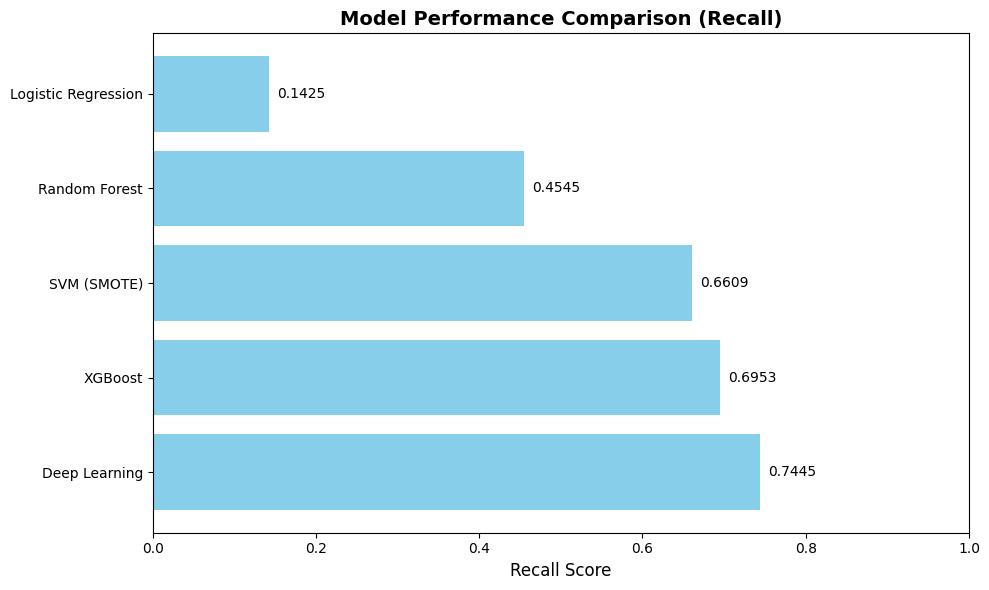


✅ All models trained successfully!


In [12]:
results = {
    'Model': ['Logistic Regression', 'Random Forest', 'SVM (SMOTE)', 'XGBoost', 'Deep Learning'],
    'Recall': [lr_recall, rf_recall, svm_recall, xgb_recall, dl_recall]
}

results_df = pd.DataFrame(results)
results_df = results_df.sort_values('Recall', ascending=False)
print(results_df.to_string(index=False))

# Visualize
plt.figure(figsize=(10, 6))
plt.barh(results_df['Model'], results_df['Recall'], color='skyblue')
plt.xlabel('Recall Score', fontsize=12)
plt.title('Model Performance Comparison (Recall)', fontsize=14, fontweight='bold')
plt.xlim(0, 1)
for i, v in enumerate(results_df['Recall']):
    plt.text(v + 0.01, i, f'{v:.4f}', va='center')
plt.tight_layout()
plt.show()

print("\n✅ All models trained successfully!")

# Download All Models

In [13]:
from google.colab import files
import os

model_files = [
    'logistic_regression.pkl',
    'random_forest.pkl',
    'svm_smote.pkl',
    'xgboost.pkl',
    'deep_learning.h5',
    'scaler_deep_learning.pkl',
    'label_encoder_geography.pkl', # Added LabelEncoder for Geography
    'label_encoder_gender.pkl'     # Added LabelEncoder for Gender
]

# Clean up any old, unneeded label encoder files (if they were generated before)
if os.path.exists('label_encoder_geography.pkl'):
    os.remove('label_encoder_geography.pkl')
    print("🗑️ Removed: label_encoder_geography.pkl")
if os.path.exists('label_encoder_gender.pkl'):
    os.remove('label_encoder_gender.pkl')
    print("🗑️ Removed: label_encoder_gender.pkl")

# Save LabelEncoders
with open('label_encoder_geography.pkl', 'wb') as f:
    pickle.dump(le_geo, f)
    print("✅ LabelEncoder for Geography saved: label_encoder_geography.pkl")

with open('label_encoder_gender.pkl', 'wb') as f:
    pickle.dump(le_gender, f)
    print("✅ LabelEncoder for Gender saved: label_encoder_gender.pkl")


# Construct the zip command with explicit files
zip_command_files = ' '.join(model_files)
!zip -r models.zip {zip_command_files}

print("\n📦 Downloading models.zip...")
print("   This file contains all model files including encoders")
print("   Extract this on your computer and upload to GitHub")
print()

files.download('models.zip')

print("\n✅ Download complete!")
print("\nNext steps:")
print("1. Extract models.zip on your computer")
print("2. Upload all .pkl and .h5 files to GitHub in 'models/' folder")
print("3. Deploy to Render")

🗑️ Removed: label_encoder_geography.pkl
✅ LabelEncoder for Geography saved: label_encoder_geography.pkl
✅ LabelEncoder for Gender saved: label_encoder_gender.pkl
  adding: logistic_regression.pkl (deflated 29%)
  adding: random_forest.pkl (deflated 79%)
  adding: svm_smote.pkl (deflated 70%)
  adding: xgboost.pkl (deflated 71%)
  adding: deep_learning.h5 (deflated 32%)
  adding: scaler_deep_learning.pkl (deflated 20%)
  adding: label_encoder_geography.pkl (deflated 16%)
  adding: label_encoder_gender.pkl (deflated 15%)

📦 Downloading models.zip...
   This file contains all model files including encoders
   Extract this on your computer and upload to GitHub



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


✅ Download complete!

Next steps:
1. Extract models.zip on your computer
2. Upload all .pkl and .h5 files to GitHub in 'models/' folder
3. Deploy to Render
